# NLP disaster Tweets

Twitter has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies)

# 1- Importing Libraries:

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re ##regular expression library .
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer , TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 2- Read the Data:

In [2]:
train=pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

- Explian the dataset:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)


`id` - a unique identifier for each tweet

`text` - the text of the tweet

`location` - the location the tweet was sent from (may be blank)

`keyword` - a particular keyword from the tweet (may be blank)

`target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [3]:
train.head(15)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.shape

(7613, 5)

# 3- EDA:

- **Disaster tweets:**

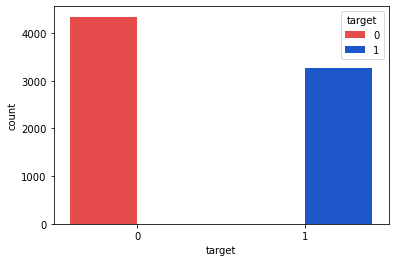

In [6]:
fig = plt.figure()
sns.countplot(train['target'],  hue=train['target'],palette= ["#ff3333","#004de6"])
fig.savefig('disaster_notdisaster.png')

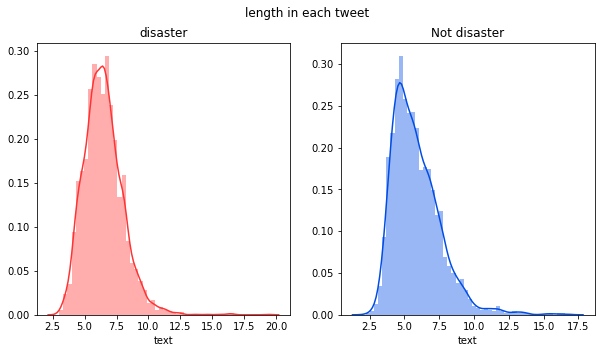

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

txt=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(txt.map(lambda x: np.mean(x)),ax=ax2,color='#004de6')
ax2.set_title('Not disaster')


txt=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(txt.map(lambda x: np.mean(x)),ax=ax1,color='#ff3333')
ax1.set_title('disaster')

fig.suptitle('length in each tweet')
fig.savefig('lengthofdisaster.png')

In [9]:
text_len=train[train['target']==1]['text'].str.len().max()
print(f'The maxmum length of disaster tweets:',text_len)

The maxmum length of disaster tweets: 151


In [10]:
text_len=train[train['target']==0]['text'].str.len().max()
print(f'The maxmum length of NOT disaster tweets:',text_len)

The maxmum length of NOT disaster tweets: 157


- **target analysis:**

In [11]:
avg_disaster=train[train['target']==1]['target'].count()
print(f'The average of disaster tweets:',avg_disaster/100,'%')

The average of disaster tweets: 32.71 %


In [12]:
avg_disaster=train[train['target']==0]['target'].count()
print(f'The average of not disaster tweets:',avg_disaster/100,'%')

The average of not disaster tweets: 43.42 %


In [13]:
train['T_mean'] = train.groupby('keyword')['target'].mean()

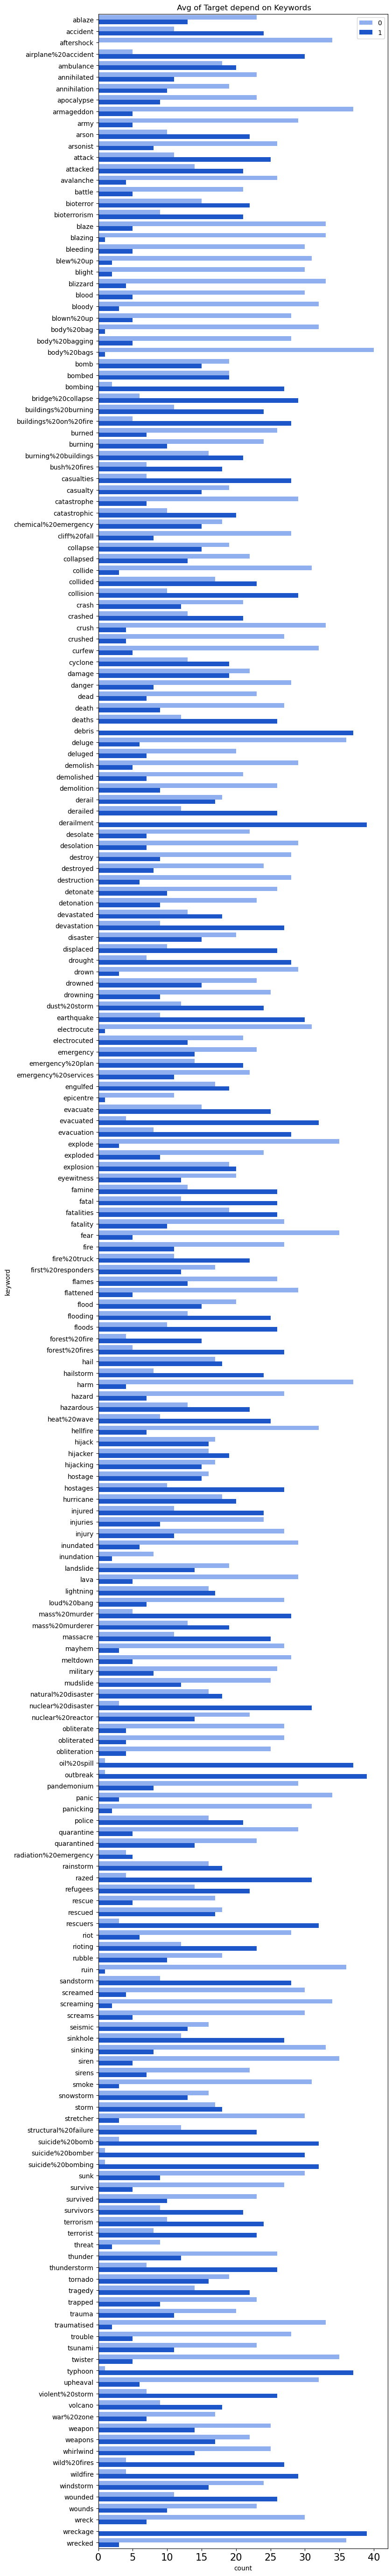

In [14]:
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='T_mean', ascending=True)['keyword'],
              hue=train.sort_values(by='T_mean', ascending=True)['target'] ,  palette= ["#80aaff","#004de6"])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title(' Avg of Target depend on Keywords')

plt.show()
fig.savefig('Avg of Target depend on Keywords.png')

In [18]:
train.drop(columns=['T_mean'], inplace=True)

In [16]:
train['length'] = train['text'].apply(lambda x: len(word_tokenize(x)))
train

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,14
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,8
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,24
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,18
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,13
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,24
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,15
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,21


In [19]:
train[train.target == 0 ]

,id,keyword,location,text,target,length
15,23,NaN,NaN,What's up man?,0,5
16,24,NaN,NaN,I love fruits,0,3
17,25,NaN,NaN,Summer is lovely,0,3
18,26,NaN,NaN,My car is so fast,0,5
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,9
...,...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,18
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0,16
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0,18
7587,10841,NaN,NaN,Sirens everywhere!,0,3


In [20]:
train[train.target == 1]

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,14
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,8
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,24
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,18
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,13
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,24
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,15
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,21


In [21]:
train.drop(columns=['length'], inplace=True)

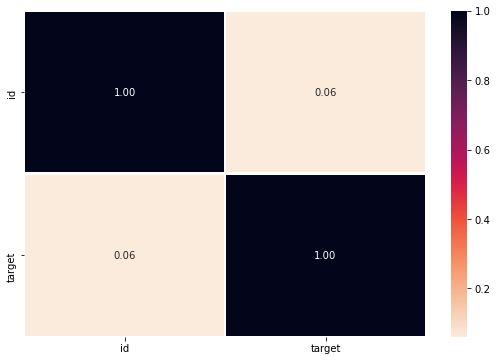

In [22]:
corr = train.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax ,  cmap='rocket_r')
plt.show()

#  4- Preparing data:

- **missing Values:**

In [4]:
print("missing values: Training set")
missing_values = train.isna().sum()
missing_values

missing values: Training set


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
print("missing values: testing set")
missing_values = test.isna().sum()
missing_values

missing values: testing set


id             0
keyword       26
location    1105
text           0
dtype: int64

In [24]:
 for df in [train , test]:
    for e in ['keyword', 'location']:
        df[e] = df[e].fillna('No_data')

 - **Preprocessing :**

- Removing stop word

In [25]:
nltk.download('wordnet')
nltk.download('stopwords')
stoplist = set(stopwords.words('english'))

test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
test.head()
train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
train.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,No_data,No_data,Our Deeds are the Reason of this #earthquake M...,1
1,4,No_data,No_data,Forest fire near La Ronge Sask. Canada,1
2,5,No_data,No_data,All residents asked to 'shelter in place' are ...,1
3,6,No_data,No_data,"13,000 people receive #wildfires evacuation or...",1
4,7,No_data,No_data,Just got sent this photo from Ruby #Alaska as ...,1


- remove URLS and special character :
- text lemmatization: 
- text stemming :

In [26]:
def Clean(text):
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text) #remove URL
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>') #remove special character 
    
    text = re.sub(r"(?:\@)\w+", '', text)
    text=text.encode("ascii",errors="ignore").decode()
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
   
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

def stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

def lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text


In [28]:
train['text']=train['text'].apply(lambda x: Clean(x))
test['text']=test['text'].apply(lambda x: Clean(x))

- tokenizing:

In [29]:
train['text_tokens'] = train['text'].apply(lambda x: word_tokenize(x))
test['text_tokens']  = train['text'].apply(lambda x: word_tokenize(x))
train.head()


,id,keyword,location,text,target,text_tokens
0,1,No_data,No_data,Our Deeds are the Reason of this earthquake Ma...,1,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,No_data,No_data,Forest fire near La Ronge Sask Canada,1,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,No_data,No_data,All residents asked to shelter in place are be...,1,"[All, residents, asked, to, shelter, in, place..."
3,6,No_data,No_data,13000 people receive wildfires evacuation orde...,1,"[13000, people, receive, wildfires, evacuation..."
4,7,No_data,No_data,Just got sent this photo from Ruby Alaska as s...,1,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [30]:
train['text_tokens']=train['text'].apply(lambda x: stemmer(x))
test['text_tokens']=test['text'].apply(lambda x: stemmer(x))

train['text_tokens']=train['text'].apply(lambda x: lemmatizer(x))
test['text_tokens']=test['text'].apply(lambda x: lemmatizer(x))

In [31]:
train['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    The out of control wild fires in California ev...
7610              M194 [0104 UTC]?5km S of Volcano Hawaii
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7613, dtype: object

In [32]:
test['text']

0                      Just happened a terrible car crash
1       Heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   Apocalypse lighting Spokane wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS...
3259    Storm in RI worse than last hurricane My citya...
3260                     Green Line derailment in Chicago
3261             MEG issues Hazardous Weather Outlook HWO
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 3263, dtype: object

In [33]:
train['text'][5]

'RockyFire Update California Hwy 20 closed in both directions due to Lake County fire CAfire wildfires'

In [34]:
test['text'][3260]

'Green Line derailment in Chicago'

In [35]:
train['text_tokens'][7]

['I',
 'm',
 ' ',
 'o',
 'n',
 ' ',
 't',
 'o',
 'p',
 ' ',
 'o',
 'f',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'h',
 'i',
 'l',
 'l',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'I',
 ' ',
 'c',
 'a',
 'n',
 ' ',
 's',
 'e',
 'e',
 ' ',
 'a',
 ' ',
 'f',
 'i',
 'r',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'w',
 'o',
 'o',
 'd',
 's']

In [36]:
test['text_tokens'][7]

['H',
 'e',
 'y',
 '!',
 ' ',
 'H',
 'o',
 'w',
 ' ',
 'a',
 'r',
 'e',
 ' ',
 'y',
 'o',
 'u',
 '?']

- **Spliting data:**

In [38]:
feature=train['text']
target =train['target']

X_train, X_test, Y_train, Y_test = train_test_split(feature,target,test_size = 0.2,random_state =24)
                                                 

In [39]:
X_train

7306    Climate Change CNN weather specialist warningw...
5627    Refugee Connections Indiegogo campaign will be...
3231    Want to work in Tarzana CA? View our latest op...
7121    Slow clap for this pilot Dramatic Video Shows ...
3429    Learn How I Gained Access To The Secrets Of Th...
                              ...                        
3473    Around 10 injured in explosion in chemical par...
343     Youre on stage now! Right under the lights! Is...
6336    3 excessive engine failure rate significant ma...
899     Bloody hell what a day I havent even really do...
4514     Did you see hurricane guillermo with MeteoEarth?
Name: text, Length: 6090, dtype: object

# 5- Modeling:

- **vectorizng and fiting the data:**

- vectorizer : it will do all three steps at once. Under the hood, it computes the word counts, IDF values, and TF-IDF scores all using the same data set
- transformer: it will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency  values and only then compute the TFIDF scores.

In [40]:
vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\b[a-zA-Z]{3,}\b' ,ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
trainfeature = tfidf.fit_transform(vectorized)

In [41]:
TFIDF= TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2'
                       sublinear_tf=True)

In [42]:
TrainFeat_= TFIDF.fit_transform(X_train)

In [43]:
TestFeat_ = TFIDF.transform(X_test)

- bulid and test the model:

In [44]:
classifier = MultinomialNB()
classifier.fit(TrainFeat_,Y_train)

test_pred= classifier.predict(TestFeat_)
accuracy = accuracy_score(Y_train, classifier.predict(TrainFeat_))
accuracy

0.8691297208538588

In [45]:
testing_accuracy = accuracy_score(Y_test, test_pred)
testing_accuracy

0.8161523309258043

In [46]:
print(classification_report(Y_test, test_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       875
           1       0.89      0.65      0.75       648

    accuracy                           0.82      1523
   macro avg       0.84      0.79      0.80      1523
weighted avg       0.83      0.82      0.81      1523



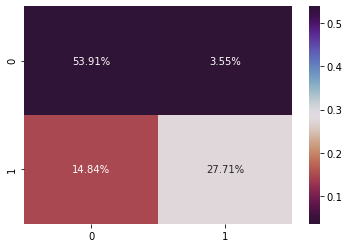

In [47]:
sns.heatmap(confusion_matrix(Y_test, test_pred)/np.sum(confusion_matrix(Y_test, test_pred)),annot=True, fmt='.2%', cmap='twilight_shifted_r')

In [51]:
tvectorizer=TFIDF.transform( train['text']).toarray()
last_predi = classifier.predict(tvectorizer)

results    = pd.DataFrame()

results['id'] = train['id']
results['target'] = last_predi

In [52]:
results

,id,target
0,1,1
1,4,1
2,5,1
3,6,1
4,7,0
...,...,...
7608,10869,1
7609,10870,1
7610,10871,1
7611,10872,1


In [53]:
result = results.to_csv('result.csv',index = False)